Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [84]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [85]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

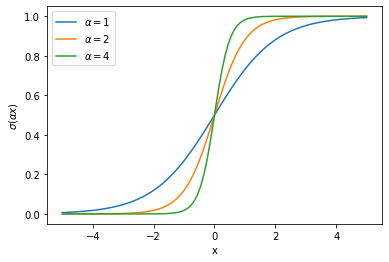

In [86]:
# Vaš kôd ovdje
def sigm(x, alpha=1):
    x_ = x*alpha
    if x_ >= 0:
        return 1. / (1 + np.exp(-x_))
    else:
        e_x_ = np.exp(x_)
        return e_x_ / (1 + e_x_)

alphas = [1, 2, 4]
xs = np.linspace(-5, 5, 100)
for alpha in alphas:
    sigm_xs = [sigm(x, alpha=alpha) for x in xs]
    plt.plot(xs, sigm_xs, label="$\\alpha = {}$".format(alpha))
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("$\\sigma\\left(\\alpha x\\right)$")
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [87]:
from numpy import linalg

def lr_h(x, w, w0):
    return sigm(np.dot(w,x) + w0)

# L(y, s(x)) =  -y ln(s(x))             - (1-y) ln(1 - s(x))
#               -y * (-ln(1 + e^-x))    - (1-y)(-x - ln(1 + e^-x))
def cross_entropy_loss_sigmoid(x, y, w, w0):
    arg = np.dot(w,x) + w0
    if arg>=32.0:
        return (1-y)*arg
    if arg<=-32.0:
        return -y*arg
    lnex = np.log(1 + np.exp(-arg))
    return y*lnex - (y-1)*(arg + lnex)

def cross_entropy_error(X, y, w, w0):
    err = 0
    for x,yy in zip(X,y):
        err += cross_entropy_loss_sigmoid(x,yy,w,w0)
    return err / len(X)


def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    # Vaš kôd ovdje
    trace_matrix_w = []
    trace_w0 = []
    n = X.shape[1]
    w = np.zeros(n)
    w0 = 0
    current_err = cross_entropy_error(X,y,w,w0)
    for k in range(max_iter):
        dw = np.zeros(n)
        dw0 = 0
        for x,yy in zip(X, y):
            h_x_ = lr_h(x, w, w0)
            dw -= (h_x_ - yy) * x
            dw0 -= (h_x_ - yy)
        w0 += eta * dw0
        w += - (eta * alpha) * w + eta * dw
        if trace:
            trace_matrix_w.append(np.copy(w))
            trace_w0.append(w0)
        new_err = cross_entropy_error(X,y,w,w0)
        err_diff = np.abs(new_err - current_err)
        current_err = new_err
        if (err_diff < epsilon):
            break
    if trace:
        return w, w0, np.array(trace_matrix_w), np.array(trace_w0)
    else:
        return w, w0


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [88]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[-1.71089242  0.68413507]
4.4544945420360165
Broj iteracija: 947
Pogreška unakrsne entropije: 0.13521872720206748


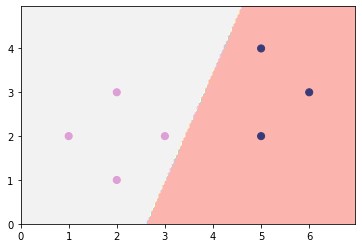

In [89]:
# Vaš kôd ovdje
w, w0, trace_w, trace_w0 = lr_train(seven_X, seven_y, trace=True)
print(w)
print(w0)
print("Broj iteracija: {}".format(len(trace_w0)))
print("Pogreška unakrsne entropije: {}".format(cross_entropy_error(seven_X, seven_y, w, w0)))
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(x, w, w0) >= 0.5)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

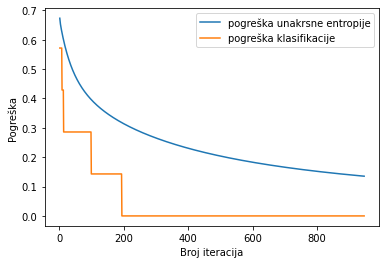

In [90]:
from sklearn.metrics import zero_one_loss

cross_entropy_err_iter = []
zero_one_loss_err_iter = []
range_list = np.arange(1,len(trace_w0)+1)
h__ = lambda x: lr_h(x, w_t, w0_t)
for w_t, w0_t in zip(trace_w, trace_w0):
    cross_entropy_err_iter.append(cross_entropy_error(seven_X, seven_y, w_t, w0_t))
    pred_classification = [lr_h(x, w_t, w0_t)>=0.5 for x in seven_X]
    zero_one_loss_err_iter.append(zero_one_loss(seven_y, pred_classification))
plt.plot(range_list, cross_entropy_err_iter, label="pogreška unakrsne entropije")
plt.plot(range_list, zero_one_loss_err_iter, label="pogreška klasifikacije")
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška")
plt.show()

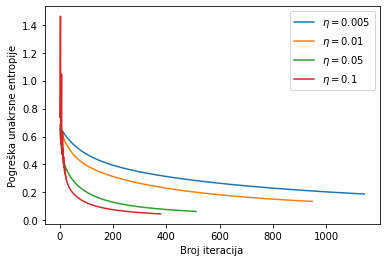

In [91]:
# Vaš kôd ovdje
etas = [0.005, 0.01, 0.05, 0.1]
for eta in etas:
    w, w0, trace_w, trace_w0 = lr_train(seven_X, seven_y, eta=eta, trace=True)
    range_list = np.arange(1,len(trace_w0)+1)
    cross_entropy_err_iter.clear()
    pred_classification.clear()
    for w_t, w0_t in zip(trace_w, trace_w0):
        cross_entropy_err_iter.append(cross_entropy_error(seven_X, seven_y, w_t, w0_t))
        for x in seven_X:
            pred_classification.append(lr_h(x, w_t, w0_t)>=0.5)
    plt.plot(range_list, cross_entropy_err_iter, label="$\\eta = {}$".format(eta))
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška unakrsne entropije")
plt.show()
    



**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

Broj iteracija: 21
Pogreška unakrsne entropije: 8.13523799378926e-06


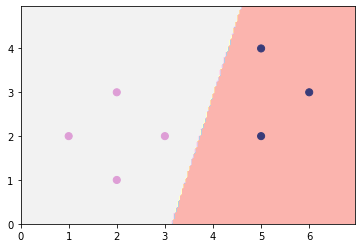

In [92]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
model = LogisticRegression(penalty="none")
model.fit(seven_X, seven_y)

print("Broj iteracija: {}".format(model.n_iter_.item()))
print("Pogreška unakrsne entropije: {}".format(cross_entropy_error(seven_X, seven_y, model.coef_[0], model.intercept_.item())))
plot_2d_clf_problem(seven_X, seven_y, lambda x: model.predict(x))


### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [93]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

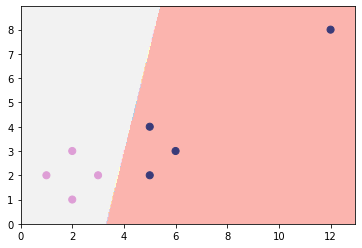

In [94]:
# Vaš kôd ovdje
model.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: model.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

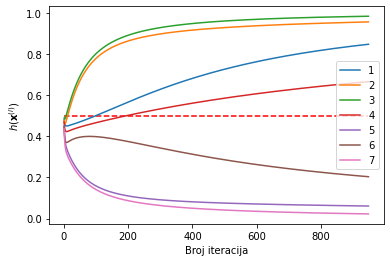

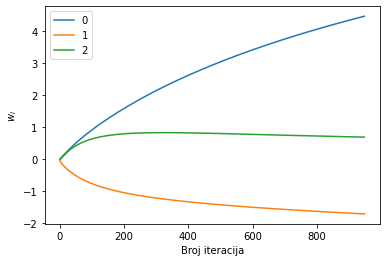

In [95]:
# Vaš kôd ovdje

def task2bc(X, y):
    w, w0, trace_w, trace_w0 = lr_train(X, y, trace=True)
    range_list = np.arange(1, len(trace_w0)+1)
    half_line = [0.5] * len(trace_w0)
    h_examples = []
    for i in range(len(X)):
        h_examples.append([])
    for w_t, w0_t in zip(trace_w, trace_w0):
        for i,x in enumerate(X):
            h_examples[i].append(lr_h(x, w_t, w0_t))

    plt.plot(range_list, half_line, "r--")
    for i,h_ex in enumerate(h_examples, start=1):
        plt.plot(range_list, h_ex, label="{}".format(i))
    plt.legend(loc="best")
    plt.xlabel("Broj iteracija")
    plt.ylabel("$h \\left( \\mathbf{x}^{(i)} \\right)$")
    plt.show()

    plt.plot(range_list, trace_w0, label="0")
    feats = trace_w.shape[1]
    for i in range(feats):
        plt.plot(range_list, trace_w[:,i], label="{}".format(i+1))
    plt.legend(loc="best")
    plt.xlabel("Broj iteracija")
    plt.ylabel("$w_i$")
    plt.show()

task2bc(seven_X, seven_y)

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

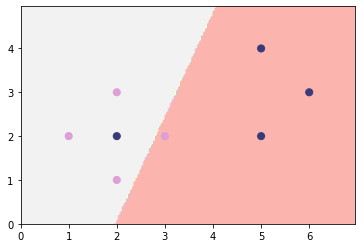

In [96]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

w,w0 = lr_train(unsep_X, unsep_y)
plot_2d_clf_problem(unsep_X, unsep_y, lambda x:lr_h(x,w,w0) >= 0.5)

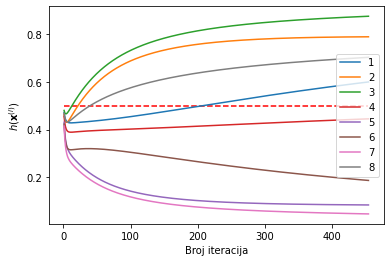

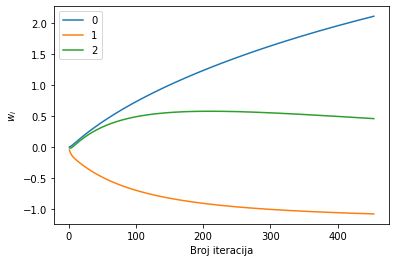

In [97]:
# Vaš kôd ovdje

task2bc(unsep_X, unsep_y)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [98]:
from numpy.linalg import norm

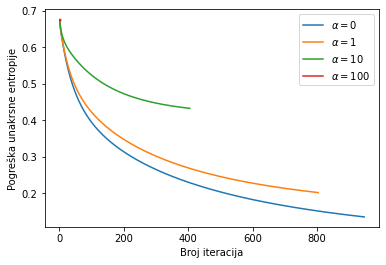

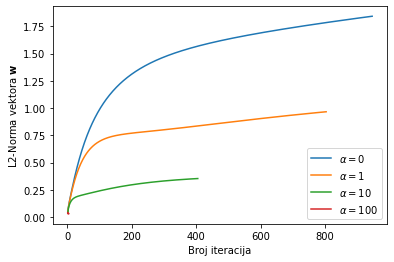

In [99]:
# Vaš kôd ovdje
alphas = [0, 1, 10, 100]

alpha_errs = {}
alpha_norms = {}
for alpha in alphas:
    w, w0, trace_w, trace_w0 = lr_train(seven_X, seven_y, alpha=alpha, trace=True)
    range_list = np.arange(1,len(trace_w0)+1)
    cross_entropy_err_iter = []
    norms_iter = []
    for w_t, w0_t in zip(trace_w, trace_w0):
        cross_entropy_err_iter.append(cross_entropy_error(seven_X, seven_y, w_t, w0_t))
        norms_iter.append(norm(w_t))
    alpha_errs[alpha] = cross_entropy_err_iter
    alpha_norms[alpha] = norms_iter

#iscrtavanje
for alpha in alphas:
    cerrs = alpha_errs[alpha]
    itlist = np.arange(1,len(cerrs)+1)
    plt.plot(itlist, cerrs, label="$\\alpha = {}$".format(alpha))
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška unakrsne entropije")
plt.show()

for alpha in alphas:
    norms = alpha_norms[alpha]
    itlist = np.arange(1,len(norms)+1)
    plt.plot(itlist, norms, label="$\\alpha = {}$".format(alpha))
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("L2-Norma vektora $\\mathbf{w}$")
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

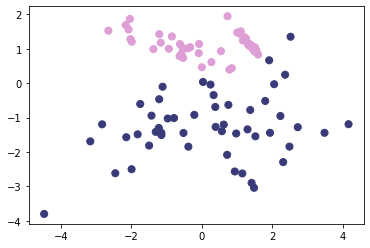

In [100]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

n_samples = 100
n_features = 2
n_classes = 2
n_clusters_per_class = 2
random_state = 150
class_sep = 1.25

X, y = make_classification(n_samples=n_samples, n_features=n_features, \
    n_informative=n_features, n_redundant=0, n_classes=n_classes, n_clusters_per_class=n_clusters_per_class, \
    flip_y=0.0, random_state=random_state, class_sep=class_sep)

plot_2d_clf_problem(X,y)

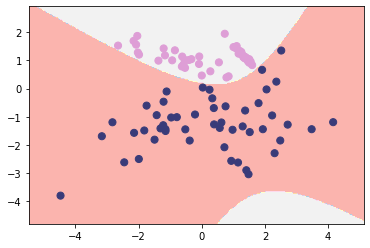

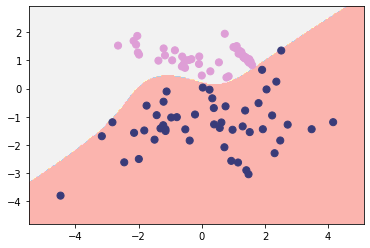

In [101]:
# Vaš kôd ovdje
poly_deg2 = PolynomialFeatures(degree=2, include_bias=False)
poly_deg3 = PolynomialFeatures(degree=3, include_bias=False)
phi_deg2 = poly_deg2.fit_transform(X)
phi_deg3 = poly_deg3.fit_transform(X)

model = LogisticRegression(penalty="none")
model.fit(phi_deg2, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(poly_deg2.fit_transform(x)))
plt.show()
model.fit(phi_deg3, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(poly_deg3.fit_transform(x)))
plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?